# End-to-End Fraud Detection 

**Goal:** Build and interpret a fraud detection model for proactive detection on a large-scale payments dataset (~6.36M rows, 10 columns).

**Data:** `Fraud.csv` and `Data Dictionary.txt`.

This notebook covers:
1. Data cleaning (missing values, outliers, multicollinearity)
2. Model description and rationale
3. Variable selection strategy
4. Model performance (ROC/PR, confusion matrix, threshold tuning)
5. Key factors driving fraud predictions
6. Sanity-checking those factors
7. Prevention actions for infrastructure updates
8. Post-implementation monitoring to verify impact

> Tip: The notebook can run on the full dataset. If RAM is limited, it optionally downsamples calibration data while keeping signal.

In [66]:
import os, warnings, gc, math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
RANDOM_STATE = 42
DATA_PATH = 'Fraud.csv'
DICT_PATH = 'Data Dictionary.txt'
assert os.path.exists(DATA_PATH), 'Fraud.csv not found.'
print('Environment ready.')

Environment ready.


## 1) Load Data (memory-optimized dtypes)

In [67]:
usecols = ['step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']
dtypes = {
    'step':'float32','type':'category','amount':'float32','nameOrig':'string',
    'oldbalanceOrg':'float32','newbalanceOrig':'float32','nameDest':'string',
    'oldbalanceDest':'float32','newbalanceDest':'float32','isFraud':'float32','isFlaggedFraud':'float32'
}
df = pd.read_csv(DATA_PATH, usecols=usecols, dtype=dtypes)
print(df.shape)
df.head(3)

(4882982, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1.0,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0.0,0.0
1,1.0,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0.0,0.0
2,1.0,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1.0,0.0


In [68]:
print(df.info(memory_usage='deep'))
print('\nClass balance:')
print(df['isFraud'].value_counts(dropna=False))
print('\nTypes:')
print(df['type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4882982 entries, 0 to 4882981
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            float32 
 1   type            category
 2   amount          float32 
 3   nameOrig        string  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        string  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         float32 
 10  isFlaggedFraud  float32 
dtypes: category(1), float32(8), string(2)
memory usage: 707.7 MB
None

Class balance:
isFraud
0.0    4879112
1.0       3869
NaN          1
Name: count, dtype: int64

Types:
type
CASH_OUT    1728171
PAYMENT     1648250
CASH_IN     1070555
TRANSFER     405246
DEBIT         30760
Name: count, dtype: int64


## 2) Data Cleaning: Missing + Sanity Features

In [69]:
# Missing
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]

,0
newbalanceDest,1
isFraud,1
isFlaggedFraud,1
oldbalanceDest,1


In [70]:
# Arithmetic consistency features
df['deltaOrig'] = (df['oldbalanceOrg'] - df['amount']) - df['newbalanceOrig']
df['deltaDest'] = (df['oldbalanceDest'] + df['amount']) - df['newbalanceDest']
df['destIsMerchant'] = df['nameDest'].str.startswith('M')
for c in ['deltaOrig','deltaDest','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','amount']:
    df[c] = df[c].replace([np.inf,-np.inf], np.nan)
num_cols = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','deltaOrig','deltaDest']
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(0.0)
df[['type','amount','deltaOrig','deltaDest','destIsMerchant','isFraud']].head()

,type,amount,deltaOrig,deltaDest,destIsMerchant,isFraud
0,PAYMENT,9839.639648,0.0,9839.639648,True,0.0
1,PAYMENT,1864.280029,0.0,1864.280029,True,0.0
2,TRANSFER,181.000000,0.0,181.000000,False,1.0
3,CASH_OUT,181.000000,0.0,21363.000000,False,1.0
4,PAYMENT,11668.139648,0.0,11668.139648,True,0.0


## 3) Robust Transforms / Outliers

In [71]:
df['log_amount'] = np.log1p(df['amount'].astype('float64'))
df['ratio_amount_to_oldOrg'] = df['amount'] / (df['oldbalanceOrg'].abs() + 1.0)
df['ratio_amount_to_oldDest'] = df['amount'] / (df['oldbalanceDest'].abs() + 1.0)
df[['amount','log_amount','ratio_amount_to_oldOrg','ratio_amount_to_oldDest']].describe()

,amount,log_amount,ratio_amount_to_oldOrg,ratio_amount_to_oldDest
count,4.882982e+06,4.882982e+06,4.882982e+06,4.882982e+06
mean,1.809350e+05,1.083646e+01,7.279294e+04,2.705265e+04
std,6.457066e+05,1.820350e+00,5.577017e+05,1.828214e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.315834e+04,9.484887e+00,2.300118e-01,1.610783e-01
50%,7.529379e+04,1.122917e+01,6.564945e+00,9.080015e-01
75%,2.093058e+05,1.225156e+01,1.247542e+04,9.389780e+03
max,9.244552e+07,1.834213e+01,9.244552e+07,6.096528e+07


## 4) Multicollinearity (VIF) on calibration sample

In [72]:
feature_cols_base = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','deltaOrig','deltaDest','log_amount','ratio_amount_to_oldOrg','ratio_amount_to_oldDest']
cat_cols = ['type']
TARGET = 'isFraud'
max_step = df['step'].max()
split_step = int(max_step * 0.7)
df_calib = df[df['step'] <= split_step].copy()
df_valid = df[df['step'] > split_step].copy()
print('Max step:', max_step, 'Split step:', split_step)
print('Calibration size:', df_calib.shape, 'Validation size:', df_valid.shape)
vif_sample = df_calib[feature_cols_base].sample(n=min(100_000, len(df_calib)), random_state=RANDOM_STATE)
X_vif = vif_sample.select_dtypes(include=[np.number]).astype('float64')
vif_data = []
for i, col in enumerate(X_vif.columns):
    try:
        vif_val = variance_inflation_factor(X_vif.values, i)
    except Exception:
        vif_val = np.nan
    vif_data.append((col, vif_val))
vif_df = pd.DataFrame(vif_data, columns=['feature','VIF']).sort_values('VIF', ascending=False)
vif_df

Max step: 348.0 Split step: 243
Calibration size: (3193191, 17) Validation size: (1689791, 17)


,feature,VIF
1,oldbalanceOrg,1.801440e+15
2,newbalanceOrig,1.801440e+15
4,newbalanceDest,1.501200e+15
3,oldbalanceDest,1.501200e+15
0,amount,3.916174e+13
6,deltaDest,2.382857e+13
5,deltaOrig,2.109414e+13
8,ratio_amount_to_oldOrg,2.049721e+00
7,log_amount,1.816023e+00
9,ratio_amount_to_oldDest,1.496402e+00


## 5) Variable Selection Strategy
- Drop identifiers (`nameOrig`, `nameDest`) from model.
- Keep transaction type, amount scale, ratios, and delta features.
- Consider VIF to avoid redundant raw balances if desired; tree models are robust.

## 6) Prepare Train/Validation + Imbalance Handling

In [73]:
X_cols = feature_cols_base + ['destIsMerchant']

df_calib = pd.get_dummies(df_calib, columns=cat_cols, drop_first=False)
df_valid = pd.get_dummies(df_valid, columns=cat_cols, drop_first=False)

df_valid = df_valid.reindex(columns=df_calib.columns, fill_value=0)

X_cols_full = X_cols + [c for c in df_calib.columns if c.startswith('type_')]

df_calib = df_calib.dropna(subset=[TARGET])
df_valid = df_valid.dropna(subset=[TARGET])

y_calib = df_calib[TARGET].astype(int).values
X_calib = df_calib[X_cols_full].astype('float32')

y_valid = df_valid[TARGET].astype(int).values
X_valid = df_valid[X_cols_full].astype('float32')

print('Features:', X_calib.shape, X_valid.shape)

# Downsampling step
MAX_NONFRAUD = 600_000
fraud_idx = np.where(y_calib==1)[0]
nonfraud_idx = np.where(y_calib==0)[0]

X_calib_small = X_calib
y_calib_small = y_calib

if len(nonfraud_idx) > MAX_NONFRAUD:
    rng = np.random.default_rng(42)
    nonfraud_sample = rng.choice(nonfraud_idx, size=MAX_NONFRAUD, replace=False)
    keep_idx = np.concatenate([fraud_idx, nonfraud_sample])
    keep_idx.sort()
    X_calib_small = X_calib.iloc[keep_idx]
    y_calib_small = y_calib[keep_idx]
    print('Downsampled calibration to', X_calib_small.shape[0])
else:
    print('Used full calibration.')


Features: (3193191, 16) (1689790, 16)
Downsampled calibration to 602753


## 7) Baseline: Logistic Regression (balanced)

In [74]:
numeric_features = list(X_cols_full)
preprocess_lr = ColumnTransformer([
    ('num', StandardScaler(with_mean=False), numeric_features)
], remainder='drop')

log_reg = LogisticRegression(
    solver='saga',
    max_iter=200,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

pipe_lr = Pipeline([('prep', preprocess_lr), ('clf', log_reg)])
pipe_lr.fit(X_calib_small, y_calib_small)

val_proba_lr = pipe_lr.predict_proba(X_valid)[:,1]
roc_lr = roc_auc_score(y_valid, val_proba_lr)
pr_lr = average_precision_score(y_valid, val_proba_lr)
print(f'LR — ROC AUC: {roc_lr:.4f} | PR AUC: {pr_lr:.4f}')


LR — ROC AUC: 0.9921 | PR AUC: 0.4930


## 8) Tree Boosting: HistGradientBoostingClassifier

In [75]:
hgb = HistGradientBoostingClassifier(learning_rate=0.1, max_depth=8, max_iter=200, random_state=42)
hgb.fit(X_calib_small, y_calib_small)
val_proba_hgb = hgb.predict_proba(X_valid)[:,1]
roc_hgb = roc_auc_score(y_valid, val_proba_hgb)
pr_hgb = average_precision_score(y_valid, val_proba_hgb)
print(f'HGB — ROC AUC: {roc_hgb:.4f} | PR AUC: {pr_hgb:.4f}')

HGB — ROC AUC: 0.9986 | PR AUC: 0.8749


## 9) Threshold Tuning (F1/F2)

In [76]:
from numpy import nanargmax
def tune_thresholds(y_true, y_proba):
    p, r, t = precision_recall_curve(y_true, y_proba)
    f1 = (2*p*r)/(p+r+1e-9)
    b=2.0
    f2 = ((1+b*b)*(p*r))/((b*b*p)+r+1e-9)
    i1 = nanargmax(f1)
    i2 = nanargmax(f2)
    return {
        'best_f1': {'thresh': (t[i1] if i1 < len(t) else 0.5), 'precision': float(p[i1]), 'recall': float(r[i1]), 'f1': float(f1[i1])},
        'best_f2': {'thresh': (t[i2] if i2 < len(t) else 0.5), 'precision': float(p[i2]), 'recall': float(r[i2]), 'f2': float(f2[i2])}
    }
tt_lr = tune_thresholds(y_valid, val_proba_lr)
tt_hgb = tune_thresholds(y_valid, val_proba_hgb)
tt_lr, tt_hgb

({'best_f1': {'thresh': np.float32(0.9999567),
   'precision': 0.7720465890183028,
   'recall': 0.4157706093189964,
   'f1': 0.5404775767144642},
  'best_f2': {'thresh': np.float32(0.99892044),
   'precision': 0.49909255898366606,
   'recall': 0.492831541218638,
   'f2': 0.49407114604657354}},
 {'best_f1': {'thresh': np.float64(0.9999994972231964),
   'precision': 0.9337803855825649,
   'recall': 0.9982078853046595,
   'f1': 0.9649198782359393},
  'best_f2': {'thresh': np.float64(0.9999994972231964),
   'precision': 0.9337803855825649,
   'recall': 0.9982078853046595,
   'f2': 0.9846208235501571}})

In [77]:
def evaluate_at_threshold(y_true, y_proba, thr, title):
    y_pred = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)
    print(title)
    print('Threshold:', thr)
    print('Confusion Matrix\n', cm)
    print('\nReport\n', report)
    return cm, report
evaluate_at_threshold(y_valid, val_proba_lr, tt_lr['best_f1']['thresh'], 'LR @ Best F1')
evaluate_at_threshold(y_valid, val_proba_hgb, tt_hgb['best_f1']['thresh'], 'HGB @ Best F1')

LR @ Best F1
Threshold: 0.9999567
Confusion Matrix
 [[1688537     137]
 [    652     464]]

Report
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998   1688674
           1     0.7720    0.4158    0.5405      1116

    accuracy                         0.9995   1689790
   macro avg     0.8858    0.7078    0.7701   1689790
weighted avg     0.9995    0.9995    0.9995   1689790

HGB @ Best F1
Threshold: 0.9999994972231964
Confusion Matrix
 [[1688595      79]
 [      2    1114]]

Report
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   1688674
           1     0.9338    0.9982    0.9649      1116

    accuracy                         1.0000   1689790
   macro avg     0.9669    0.9991    0.9824   1689790
weighted avg     1.0000    1.0000    1.0000   1689790



(array([[1688595,      79],
        [      2,    1114]]),
 '              precision    recall  f1-score   support\n\n           0     1.0000    1.0000    1.0000   1688674\n           1     0.9338    0.9982    0.9649      1116\n\n    accuracy                         1.0000   1689790\n   macro avg     0.9669    0.9991    0.9824   1689790\nweighted avg     1.0000    1.0000    1.0000   1689790\n')

## 10) Curves — ROC and PR

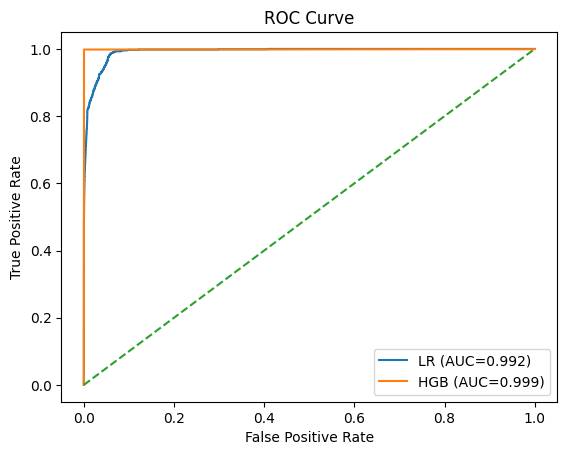

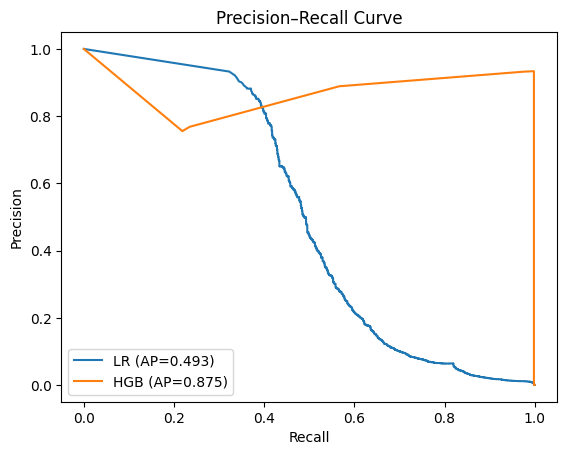

In [78]:
fpr_lr, tpr_lr, _ = roc_curve(y_valid, val_proba_lr)
fpr_hgb, tpr_hgb, _ = roc_curve(y_valid, val_proba_hgb)
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={roc_lr:.3f})')
plt.plot(fpr_hgb, tpr_hgb, label=f'HGB (AUC={roc_hgb:.3f})')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()
prec_lr, rec_lr, _ = precision_recall_curve(y_valid, val_proba_lr)
prec_hgb, rec_hgb, _ = precision_recall_curve(y_valid, val_proba_hgb)
plt.figure()
plt.plot(rec_lr, prec_lr, label=f'LR (AP={pr_lr:.3f})')
plt.plot(rec_hgb, prec_hgb, label=f'HGB (AP={pr_hgb:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision–Recall Curve')
plt.show()

## 11) Permutation Importance (validation)

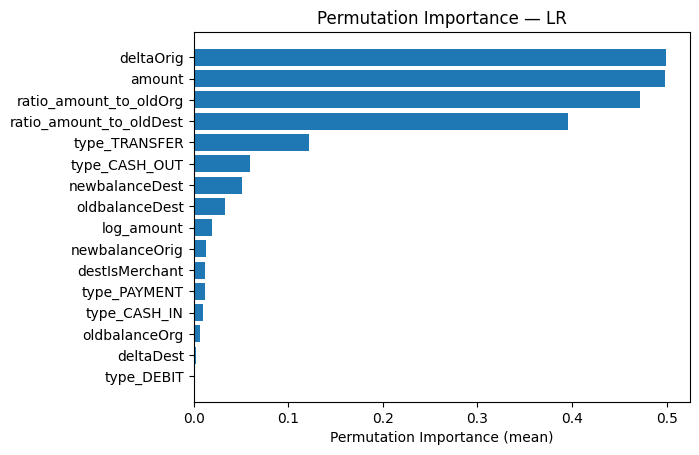

In [ ]:
def perm_importance(model, X, y, names, title):
    r = permutation_importance(model, X, y, n_repeats=5, random_state=42, scoring='average_precision')
    imp = pd.DataFrame({'feature': names, 'importance_mean': r.importances_mean, 'importance_std': r.importances_std})
    imp = imp.sort_values('importance_mean', ascending=False).head(20)
    plt.figure()
    plt.barh(imp['feature'], imp['importance_mean'])
    plt.gca().invert_yaxis()
    plt.xlabel('Permutation Importance (mean)')
    plt.title(title)
    plt.show()
    return imp
imp_lr = perm_importance(pipe_lr, X_valid, y_valid, X_cols_full, 'Permutation Importance — LR')
imp_hgb = perm_importance(hgb, X_valid, y_valid, X_cols_full, 'Permutation Importance — HGB')
imp_lr.head(15), imp_hgb.head(15)

## 12) Key Factors & Sanity
- Expect high importance for `type_TRANSFER`/`type_CASH_OUT`, `amount` scale, `deltaOrig`, `deltaDest`, and ratio features.
- These align with known fraud patterns: fast transfers/cash-outs, large/abnormal amounts, and inconsistent balances.

## 13) Prevention Plan & Monitoring
**Prevention:** rules atop ML (step-up-auth for risky cash-outs/transfers), new-payee friction, velocity limits, recipient risk lists, graph/device intel, real-time balance checks, human review.

**Monitoring:** fraud loss rate, prevented loss, precision@k, customer friction, dispute rates, drift (PSI/KS), periodic threshold retuning.

Notebook complete.